In [1]:
# Imports
import torch
import torch.nn.functional as F

import numpy as np
import os
from PIL import Image

import sys
sys.path.append("../models/")

# Add the upper directory to the path
sys.path.append("../models/")
from CustomCNNVessel import CustomResNet
sys.path.append("../data/")
from VessMapDatasetLoader import vess_map_dataloader

torch.cuda.empty_cache()
device = torch.device("cuda")

In [ ]:
""" # Dataloaders
image_dir = '/home/fonta42/Desktop/interpretacao-redes-neurais/data/VessMap/images'
mask_dir = '/home/fonta42/Desktop/interpretacao-redes-neurais/data/VessMap/labels'
skeleton_dir = '/home/fonta42/Desktop/interpretacao-redes-neurais/data/VessMap/skeletons'

batch_size = 10
train_size = 0.8

train_loader, test_loader = vess_map_dataloader(image_dir, 
                                  mask_dir, 
                                  skeleton_dir, 
                                  batch_size,
                                  train_size = train_size) """

In [2]:
# Models
model = CustomResNet(num_classes=2).to(device)
# Load the weights
model.load_state_dict(torch.load(f"../models/vess_map_regularized_none_200.pth"))

model = model.eval()

In [ ]:
""" all_images = []


# Iterate through the entire train_loader
for batch in train_loader:
    images, _, _ = batch
    images = images.to(device)
    all_images.extend(images)
    
for batch in test_loader:
    images, _, _ = batch
    images = images.to(device)
    all_images.extend(images) """

In [3]:
def load_images_from_directory(directory_name):
    # Get the list of image file names in sorted order
    image_files = sorted(os.listdir(directory_name))

    # Load and store the images in a list
    images = []
    for file_name in image_files:
        if file_name.endswith('.png'):
            img_path = os.path.join(directory_name, file_name)
            img = Image.open(img_path)
            img_array = np.array(img) / 255.0
            images.append(img_array)

    return torch.tensor(np.array(images), dtype=torch.float).unsqueeze(1).to('cpu')

# Load images from both directories
original_images = load_images_from_directory('./original_images')

In [4]:
def compute_softmax_gradient(model, image, x_pixel, y_pixel, threshold_proportion):
    # Ensure image requires gradient
    image = image.unsqueeze(0).requires_grad_()

    # Forward pass
    out = model(image)

    # Apply softmax to the output to get class probabilities
    probabilities = F.softmax(out, dim=1)

    score = probabilities[0, 1, x_pixel, y_pixel]  # Probability of class 1 at (x, y)

    # Compute gradients
    score.backward()

    gradient = image.grad.squeeze().cpu().numpy()
    # Return the gradient
    threshold = np.max(gradient) * threshold_proportion
    mask = np.abs(gradient) > threshold
    non_zero_coords = np.nonzero(mask)
    
    if len(non_zero_coords[0]) > 0:
        y_min, y_max = non_zero_coords[0].min(), non_zero_coords[0].max()
        x_min, x_max = non_zero_coords[1].min(), non_zero_coords[1].max()
        num_pixels_above_threshold = np.sum(mask)
        bounding_box_area = (y_max - y_min + 1) * (x_max - x_min + 1)
        #fulfillment = num_pixels_above_threshold / bounding_box_area
        return bounding_box_area
    return 0

In [5]:
def get_all_gradients(model, image, sampling_rate = 10, device = "cuda", vectorize = False):
  torch.cuda.empty_cache()

  model.to(device)
  model = model.eval()
  image = image.to(device).unsqueeze(0)
  sampled_image = image[:,:,::sampling_rate,::sampling_rate].to(device)
  sampled_image.requires_grad = True
  
  jacobian_gradient = torch.autograd.functional.jacobian(model, 
                                                         sampled_image,
                                                         vectorize = vectorize)
  jacobian_gradient = jacobian_gradient.squeeze()
  return jacobian_gradient.to('cpu')

In [6]:
gradients = []
for img in original_images[:1]:
  torch.cuda.empty_cache()
  gradient = get_all_gradients(model, original_images[0], sampling_rate = 10, device = "cuda", vectorize = True)
  gradients.append(gradient)

gradients[0].shape

torch.Size([2, 23, 23, 23, 23])

In [88]:
def compute_bounding_box_area(model, image, threshold_proportion):
    
    # Dimensions of the original image
    height, width = image.shape[1], image.shape[2]
    # Sampling ratio
    sampling = 5

    jacobian_gradients = get_all_gradients(model, image, sampling_rate = sampling, device = 'cuda')
    
    # Generate arrays of indices for rows and columns
    row_indices = np.arange(0, height, sampling)
    col_indices = np.arange(0, width, sampling)

    # Create a meshgrid of indices
    row_indices, col_indices = np.meshgrid(row_indices, col_indices)

    # Flatten the arrays to get a list of (row, col) pairs
    sampled_pixel_indices = np.vstack([row_indices.flatten(), col_indices.flatten()]).T

    fulfillment_image = np.zeros_like(jacobian_gradients[1, 0, 0])
    for pixel_coord in sampled_pixel_indices:
        # Return the gradient
        
        gradient = jacobian_gradients[1, int(pixel_coord[0] / 5), int(pixel_coord[1] / 5)]
        
        threshold = np.max(gradient.detach().cpu().numpy()) * threshold_proportion
        mask = np.abs(gradient.detach().cpu().numpy()) > threshold
        non_zero_coords = np.nonzero(mask)
        
        if len(non_zero_coords[0]) > 0:
            y_min, y_max = non_zero_coords[0].min(), non_zero_coords[0].max()
            x_min, x_max = non_zero_coords[1].min(), non_zero_coords[1].max()
            num_pixels_above_threshold = np.sum(mask)
            bounding_box_area = (y_max - y_min + 1) * (x_max - x_min + 1)
            #fulfillment = num_pixels_above_threshold / bounding_box_area
            fulfillment_image[int(pixel_coord[0] / 5), int(pixel_coord[1] / 5)] = num_pixels_above_threshold
        else:
            fulfillment_image[int(pixel_coord[0] / 5), int(pixel_coord[1] / 5)] = 0
        
    return fulfillment_image

In [89]:
threshold_proportion = 0.1
fulfillment_images = []
for idx, input_image in enumerate(original_images):
    fulfillment_image = compute_bounding_box_area(model, input_image, threshold_proportion)

    # Normalize the fulfillment image to the range [0, 1]
    fulfillment_image = (fulfillment_image - np.min(fulfillment_image)) / (np.max(fulfillment_image) - np.min(fulfillment_image))

    fulfillment_images.append(fulfillment_image)
    if idx % 10 == 0:
        print(f'{idx} images processed')

0 images processed
10 images processed
20 images processed
30 images processed
40 images processed
50 images processed
60 images processed
70 images processed
80 images processed
90 images processed


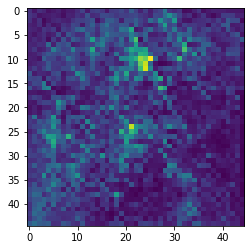

In [91]:
fulfillment_images[0].shape
plt.imshow(fulfillment_images[0])

In [66]:
import torch
import torch.nn.functional as F
import numpy as np

def resize_images_np(image_array, output_size=(224, 224)):
    # Ensure the images are in the format (num_images, height, width) as 2D arrays
    image_array = [img if img.ndim == 2 else img.squeeze() for img in image_array]

    # Stack the images and add an extra dimension for the channel
    image_tensor = torch.from_numpy(np.stack(image_array)[:, np.newaxis, :, :]).float()

    # Interpolate the images to the desired output size using nearest neighbor interpolation
    resized_images = F.interpolate(image_tensor, size=output_size, mode='nearest')

    # Convert the tensor back to a list of 2D NumPy arrays
    resized_images_list = [img.squeeze().numpy() for img in resized_images]

    return resized_images_list


resized_images_np = resize_images_np(fulfillment_images)  # Array of (224, 224) NumPy arrays

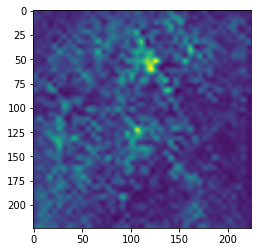

In [97]:
img = cv2.resize( fulfillment_images[0].astype('float'), ( 224, 224 ), interpolation = cv2.INTER_CUBIC )
plt.imshow(img)

fulfillment_image_resized = []
for img in fulfillment_images:
  resized = cv2.resize(img.astype('float'), ( 224, 224 ), interpolation = cv2.INTER_CUBIC )
  fulfillment_image_resized.append(resized)

In [ ]:
import os
import torch
from PIL import Image
import torchvision.transforms.functional as TF

# Function to save images in a directory
def save_images(image_array, directory_name):
    # Create the directory if it does not exist
    if not os.path.exists(directory_name):
        os.makedirs(directory_name)

    # Loop through the images and save them
    for i, img_tensor in enumerate(image_array):
        # Convert the tensor to a PIL image
        img = TF.to_pil_image(img_tensor)
        #print(img_tensor.squeeze(0).transpose(1, 2, 0).shape)
        # Convert the image to 8-bit grayscale if it's in mode 'F'
        if img.mode == 'F':
            img = img.convert('L')

        # Save the image with reduced file size
        img.save(os.path.join(directory_name, f'image_{i}.png'), 'PNG', optimize=True, quality=20)

# Save all_images and fulfillment_images
save_images(all_images, './original_images')
#save_images(fulfillment_images, './fulfillment_images')


In [38]:
#fulfillment_images = [np.expand_dims(img, axis=0) for img in fulfillment_images]
fulfillment_images[25].shape

(45, 45)

In [98]:
import os
import matplotlib.pyplot as plt

def plot_and_save_images(image_array, directory_name):
    # Create the directory if it does not exist
    if not os.path.exists(directory_name):
        os.makedirs(directory_name)

    # Loop through the images and plot/save them
    for i, img in enumerate(image_array):
        plt.figure(figsize=(225, 225), dpi=1)
        plt.imshow(img, cmap='RdYlGn')
        plt.axis('off')
        plt.tight_layout()

        # Save the plot as a PNG file
        plt.savefig(os.path.join(directory_name, f'image_{i}.png'), bbox_inches='tight', pad_inches=0)
        plt.close()  # Close the figure to free up memory

# Example usage
plot_and_save_images(fulfillment_image_resized, './fulfillment_images_2')


In [ ]:
img = Image.open('/home/fonta42/Desktop/interpretacao-redes-neurais/experiments/fulfillment_images/image_0.png')
np.array(img).shape

In [27]:
# Imports
import torch
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

idx = 10
loaded_gradient = torch.load(f'./gradients/jacobian_gradient_{idx}.pt')
loaded_gradient.shape[0]

64

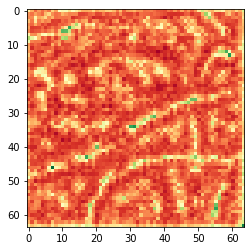

In [34]:
img = 

plt.imshow(img, cmap='RdYlGn')

In [35]:
fulfillment_image.shape

(64, 64)

In [26]:
img = np.array(fulfillment_image)
img

array([[106307., 106307., 106307., ..., 106307., 106307., 106307.],
       [106307., 106307., 106307., ..., 106307., 106307., 106307.],
       [106307., 106307., 106307., ..., 106307., 106307., 106307.],
       ...,
       [106307., 106307., 106307., ..., 106307., 106307., 106307.],
       [106307., 106307., 106307., ..., 106307., 106307., 106307.],
       [106307., 106307., 106307., ..., 106307., 106307., 106307.]],
      dtype=float32)

In [19]:
img = (img - img.min()) / (img.max() - img.min())
img

/home/fonta42/anaconda3/envs/interpreting-cnn/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

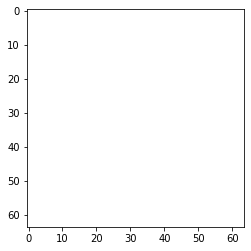

In [15]:
plt.imshow(img)